Sample Features:
    word_count  pauses  vocab_richness        steps  sleep_interruptions  \
0          10       0        0.899999  8196.499536                    1   
1          10       0        0.899999  8059.838016                    2   
2          11       3        0.999999  7866.845906                    0   
3          11       3        0.999999  7884.107087                    1   
4          10       0        0.899999  8055.233385                    4   

     label  
0  control  
1  control  
2      mci  
3      mci  
4  control  


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Report:
               precision    recall  f1-score   support

          ad       1.00      1.00      1.00        21
     control       1.00      1.00      1.00        18
         mci       1.00      1.00      1.00        21

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

Random Forest Report:
               precision    recall  f1-score   support

          ad       1.00      1.00      1.00        21
     control       1.00      1.00      1.00        18
         mci       1.00      1.00      1.00        21

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



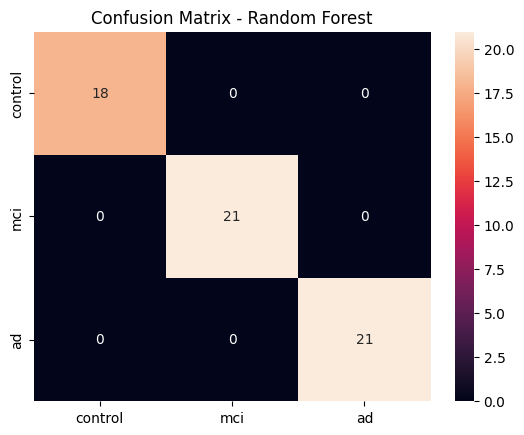

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


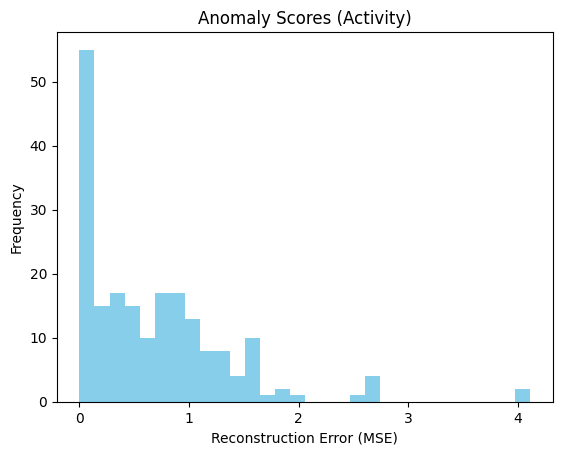

In [ ]:
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# ----------------------------
# 1. Synthetic Dataset Creation
# ----------------------------

def generate_speech_data(n=200):
    """Generate fake speech transcripts with AD vs Control patterns."""
    data = []
    for i in range(n):
        label = random.choice(["control", "mci", "ad"])
        if label == "control":
            transcript = "I went to the market and bought apples and oranges."
        elif label == "mci":
            transcript = "I um went to the uh store and got... apples maybe."
        else:  # Alzheimer's
            transcript = "I... I went... to the... uh uh store... store store."
        data.append((transcript, label))
    return pd.DataFrame(data, columns=["transcript", "label"])


def generate_activity_data(n=200):
    """Generate fake activity logs."""
    data = []
    for i in range(n):
        label = random.choice(["control", "mci", "ad"])
        if label == "control":
            steps = np.random.normal(8000, 500)
            sleep_interruptions = np.random.poisson(1)
        elif label == "mci":
            steps = np.random.normal(5000, 700)
            sleep_interruptions = np.random.poisson(2)
        else:  # Alzheimer's
            steps = np.random.normal(3000, 900)
            sleep_interruptions = np.random.poisson(4)
        data.append((steps, sleep_interruptions, label))
    return pd.DataFrame(data, columns=["steps", "sleep_interruptions", "label"])


# ----------------------------
# 2. Feature Extraction
# ----------------------------

def extract_speech_features(df):
    features = []
    for text in df["transcript"]:
        words = text.split()
        word_count = len(words)
        pauses = len(re.findall(r"\.\.\.|uh|um", text))
        vocab_richness = len(set(words)) / (word_count + 1e-5)
        features.append([word_count, pauses, vocab_richness])
    feat_df = pd.DataFrame(features, columns=["word_count", "pauses", "vocab_richness"])
    feat_df["label"] = df["label"]
    return feat_df


def extract_activity_features(df):
    return df.copy()


# ----------------------------
# 3. Merge Features
# ----------------------------

speech_df = generate_speech_data()
activity_df = generate_activity_data()

speech_feat = extract_speech_features(speech_df)
activity_feat = extract_activity_features(activity_df)

# Merge features (simulate matching subjects)
merged = pd.concat([speech_feat[["word_count","pauses","vocab_richness"]],
                    activity_feat[["steps","sleep_interruptions"]]], axis=1)
merged["label"] = speech_feat["label"]  # align labels

print("Sample Features:\n", merged.head())

# ----------------------------
# 4. Train Classifiers
# ----------------------------

X = merged.drop("label", axis=1)
y = merged["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_log))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=["control","mci","ad"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["control","mci","ad"], yticklabels=["control","mci","ad"])
plt.title("Confusion Matrix - Random Forest")
plt.show()

# ----------------------------
# 5. Autoencoder (Anomaly Detection on Activity)
# ----------------------------

X_act = activity_feat.drop("label", axis=1).values
X_act = (X_act - X_act.mean(axis=0)) / X_act.std(axis=0)  # normalize

autoencoder = Sequential([
    Dense(4, activation="relu", input_shape=(2,)),
    Dense(2, activation="relu"),
    Dense(4, activation="relu"),
    Dense(2, activation="linear")
])
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(X_act, X_act, epochs=20, batch_size=16, verbose=0)

reconstructions = autoencoder.predict(X_act)
mse = np.mean(np.power(X_act - reconstructions, 2), axis=1)

plt.hist(mse, bins=30, color="skyblue")
plt.title("Anomaly Scores (Activity)")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.show()


✅ Dataset Loaded Successfully!
Shape: (2149, 35)
   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       4751   73       0          0               2  22.927749        0   
1       4752   89       0          0               0  26.827681        0   
2       4753   73       0          3               1  17.795882        0   
3       4754   74       1          0               1  33.800817        1   
4       4755   89       0          0               0  20.716974        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...  MemoryComplaints  \
0           13.297218          6.327112     1.347214  ...                 0   
1            4.542524          7.619885     0.518767  ...                 0   
2           19.555085          7.844988     1.826335  ...                 0   
3           12.209266          8.428001     7.435604  ...                 0   
4           18.454356          6.310461     0.795498  ...                 0   

   BehavioralProble

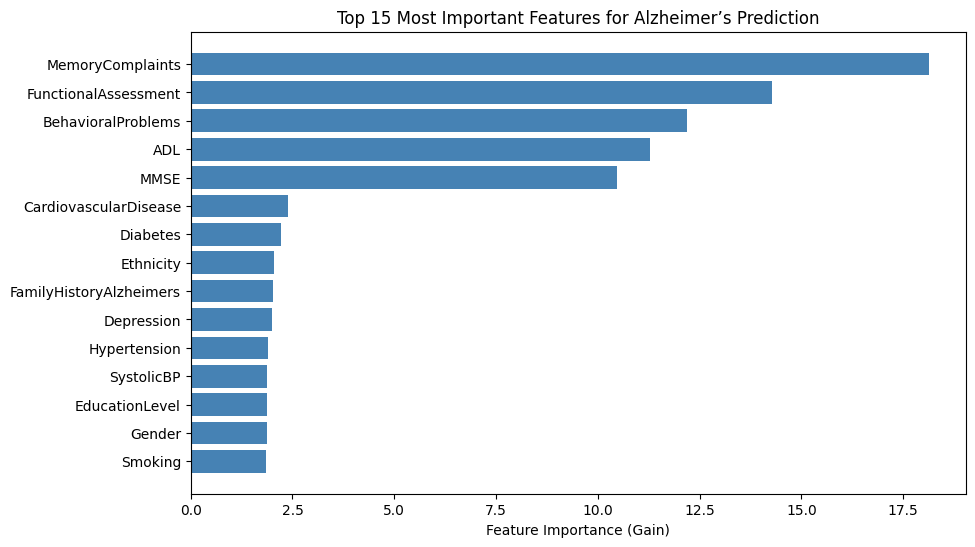


💾 Model and feature names saved as 'alzheimers_early_detection_model.pkl'


In [1]:
# ------------------------------------------------------------
# Alzheimer’s Early Detection (Tabular, Non-MRI)
# Dataset: /content/alzheimers_disease_data.csv
# Target Column: Diagnosis (0 = No Alzheimer’s, 1 = Alzheimer’s)
# ------------------------------------------------------------

!pip install -q imbalanced-learn xgboost

# ✅ Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,
                             recall_score, f1_score, confusion_matrix, classification_report)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# Step 1️⃣ : Load dataset
dataset_path = "/content/alzheimers_disease_data.csv"
df = pd.read_csv(dataset_path)
print("✅ Dataset Loaded Successfully!")
print("Shape:", df.shape)
print(df.head())

# Step 2️⃣ : Define target and features
TARGET_COL = "Diagnosis"
y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL, 'DoctorInCharge', 'PatientID'], errors='ignore')

print("\nFeature columns:", len(X.columns))
print("Target distribution:\n", y.value_counts())

# Step 3️⃣ : Preprocessing (numerical + categorical)
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # ✅ Fixed here
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

# Step 4️⃣ : Model setup (XGBoost + SMOTE)
model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=42
)

pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', model)
])

# Step 5️⃣ : Train/test split
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
print("\nData split complete.")
print("Training size:", X_train.shape, "Holdout size:", X_hold.shape)

# Step 6️⃣ : Hyperparameter tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__reg_alpha': [0, 0.1, 1],
    'clf__reg_lambda': [1, 2, 5]
}

rs = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42
)

print("\n🔄 Training and tuning model...")
rs.fit(X_train, y_train)
print("\n✅ Best Parameters:")
print(rs.best_params_)
print("Best CV ROC AUC:", rs.best_score_)

best = rs.best_estimator_

# Step 7️⃣ : Evaluate model
y_pred_cv = cross_val_predict(best, X_train, y_train, cv=cv, method='predict', n_jobs=-1)
y_proba_cv = cross_val_predict(best, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

print("\n📊 Cross-validation metrics:")
print("Accuracy:", accuracy_score(y_train, y_pred_cv))
print("ROC AUC:", roc_auc_score(y_train, y_proba_cv))
print("Precision:", precision_score(y_train, y_pred_cv))
print("Recall:", recall_score(y_train, y_pred_cv))
print("F1 Score:", f1_score(y_train, y_pred_cv))
print("\nClassification Report:\n", classification_report(y_train, y_pred_cv))

print("\n📊 Holdout set metrics:")
y_hold_pred = best.predict(X_hold)
y_hold_proba = best.predict_proba(X_hold)[:, 1]

print("Accuracy:", accuracy_score(y_hold, y_hold_pred))
print("ROC AUC:", roc_auc_score(y_hold, y_hold_proba))
print("Precision:", precision_score(y_hold, y_hold_pred))
print("Recall:", recall_score(y_hold, y_hold_pred))
print("F1 Score:", f1_score(y_hold, y_hold_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_hold, y_hold_pred))
print("\nClassification Report:\n", classification_report(y_hold, y_hold_pred))

# Step 8️⃣ : Feature Importance (fixed version — safe for Colab pipelines)
import matplotlib.pyplot as plt
import pandas as pd

# Refit the preprocessor on training data to get correct column names
preprocessor = best.named_steps['preproc']
preprocessor.fit(X_train)

num_features = num_cols
cat_features = []
if cat_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_features = list(ohe.get_feature_names_out(cat_cols))

# Combine all feature names
feature_names = num_features + cat_features

# Get XGBoost feature importances
clf = best.named_steps['clf']
importance = clf.get_booster().get_score(importance_type='gain')

# Map feature indices (f0, f1, ...) to actual column names
imp_df = pd.DataFrame([
    {"feature": feature_names[int(k[1:])], "importance": v}
    for k, v in importance.items() if k[1:].isdigit()
])

# Sort and select top 15
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

# Display top features
print("\n✅ Top 15 Important Features:\n", imp_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(imp_df['feature'], imp_df['importance'], color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance (Gain)")
plt.title("Top 15 Most Important Features for Alzheimer’s Prediction")
plt.show()

# Step 9️⃣ : Save the trained model and feature names
import joblib

joblib.dump({
    "model": best,
    "feature_names": feature_names
}, "alzheimers_early_detection_model.pkl")

print("\n💾 Model and feature names saved as 'alzheimers_early_detection_model.pkl'")


In [2]:
# Clean rebuild of booster so SHAP can read it
import tempfile, xgboost as xgb

clf = best.named_steps["clf"]

# dump model text to remove bad attributes, reload as Booster
with tempfile.NamedTemporaryFile(suffix=".json") as tmp:
    clf.save_model(tmp.name)
    booster = xgb.Booster()
    booster.load_model(tmp.name)

print("✅ Re-exported booster for SHAP; base_score fixed.")


✅ Re-exported booster for SHAP; base_score fixed.


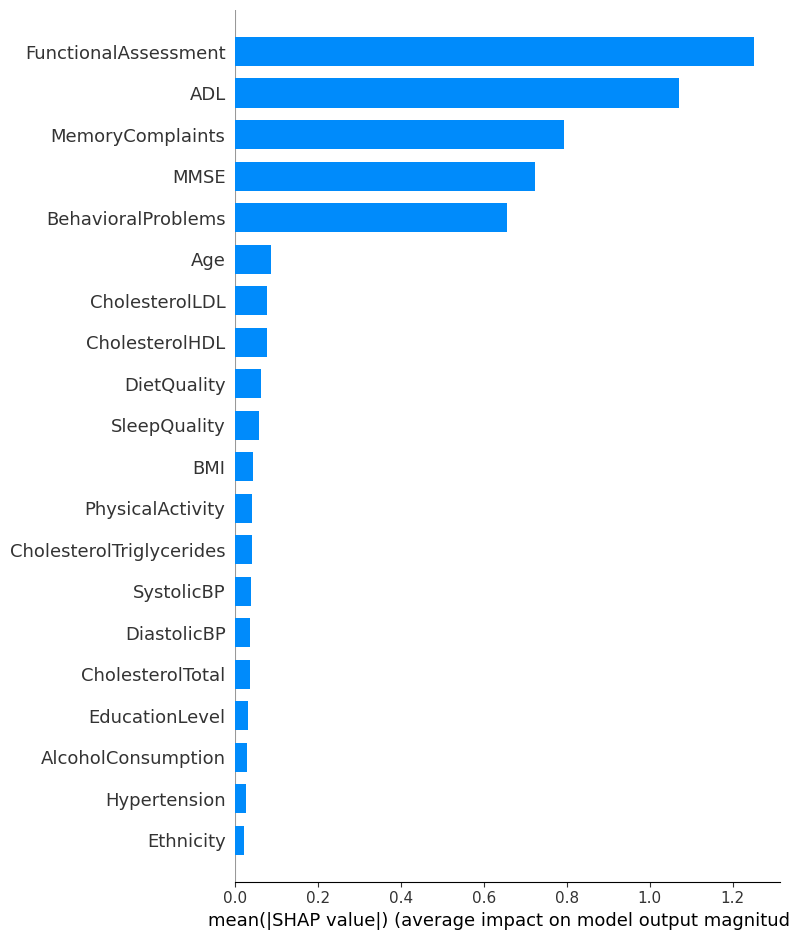

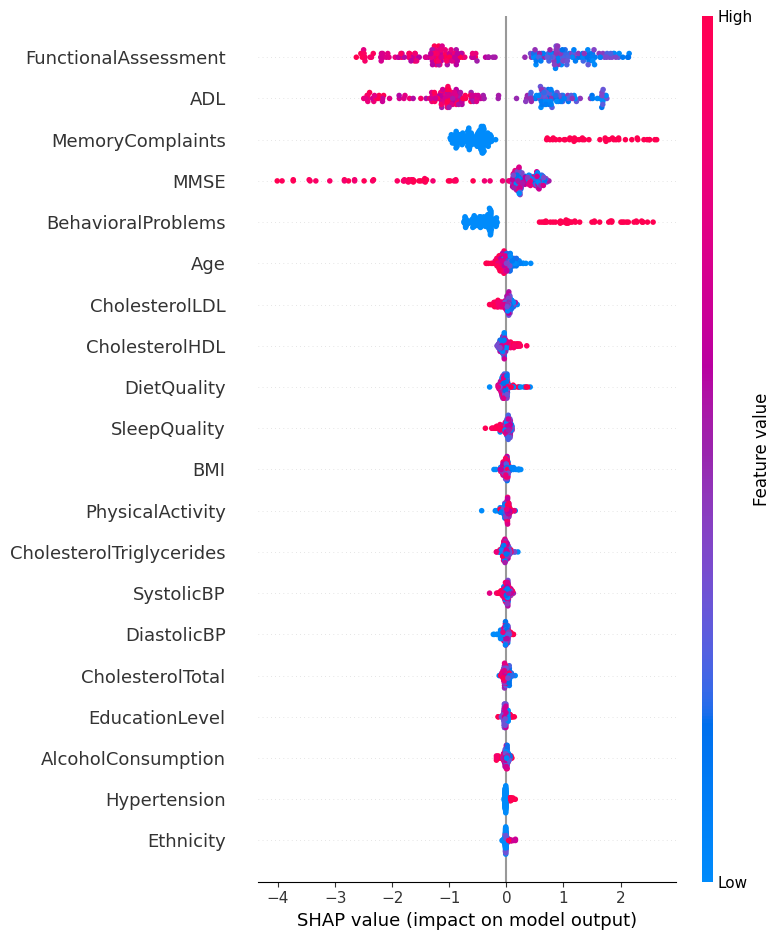

In [3]:
# ------------------------------------------------------------
# 🧠 SHAP Explainability — Direct XGBoost DMatrix route
# ------------------------------------------------------------
!pip install -q shap xgboost

import shap, xgboost as xgb
import numpy as np, pandas as pd, matplotlib.pyplot as plt

clf = best.named_steps["clf"]
preprocessor = best.named_steps["preproc"]

# pick sample, preprocess
sample_X = X_hold.sample(n=min(200, len(X_hold)), random_state=42)
X_processed = preprocessor.transform(sample_X)

# convert to DMatrix, which SHAP can read directly
dmat = xgb.DMatrix(X_processed, label=None)

# get raw booster
booster = clf.get_booster()

# compute SHAP values directly from Booster using built-in method
# (no TreeExplainer constructor = no '[5E-1]' issue)
shap_values = booster.predict(
    dmat, pred_contribs=True
)

# SHAP values are an ndarray; the last column is bias term
shap_values = shap_values[:, :-1]

# rebuild feature names
preprocessor.fit(X_train)
num_features = num_cols
cat_features = []
if cat_cols:
    ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_features = list(ohe.get_feature_names_out(cat_cols))
feature_names = num_features + cat_features

# summary plots
shap.summary_plot(shap_values, X_processed, feature_names=feature_names, plot_type="bar")
shap.summary_plot(shap_values, X_processed, feature_names=feature_names)


Patient index: 10


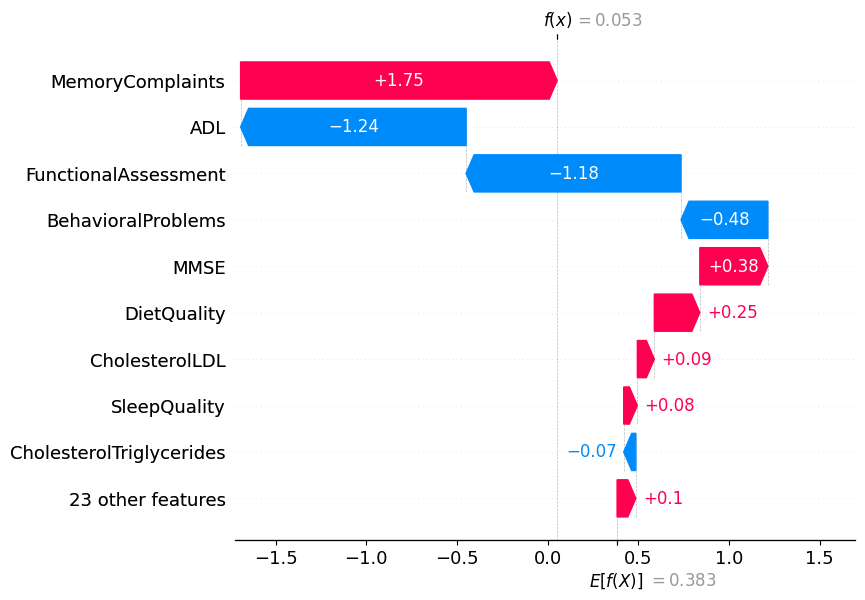

In [4]:
# pick one example patient from the holdout sample
i = 10   # try changing the index
one_row = X_hold.iloc[[i]]
print("Patient index:", i)

# preprocess and compute SHAP values
import shap, xgboost as xgb
dmat_one = xgb.DMatrix(preprocessor.transform(one_row))
shap_values_one = booster.predict(dmat_one, pred_contribs=True)[:, :-1]

# waterfall plot to show contributions
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_one[0],
        base_values=np.mean(booster.predict(xgb.DMatrix(preprocessor.transform(X_hold)))),
        feature_names=feature_names,
    )
)


In [ ]:
!pip install gradio -q
import gradio as gr
import pandas as pd

# Load trained model bundle
bundle = joblib.load("alzheimers_early_detection_model.pkl")
model = bundle["model"]

# Define all features with sensible default values
def predict_risk(
    Age=70, Gender=0, Ethnicity=0, EducationLevel=2, BMI=24.0, Smoking=0,
    AlcoholConsumption=5.0, PhysicalActivity=6.0, DietQuality=4.0, SleepQuality=6.0,
    FamilyHistoryAlzheimers=1, CardiovascularDisease=0, Diabetes=0, Depression=0,
    HeadInjury=0, Hypertension=0, SystolicBP=130, DiastolicBP=80,
    CholesterolTotal=190, CholesterolLDL=120, CholesterolHDL=50,
    CholesterolTriglycerides=150, MMSE=25, FunctionalAssessment=5.0,
    MemoryComplaints=1, BehavioralProblems=0, ADL=5.0, Confusion=0,
    Disorientation=0, PersonalityChanges=0, DifficultyCompletingTasks=0,
    Forgetfulness=0
):
    try:
        # Create dataframe for model input
        df = pd.DataFrame([locals()])  # collects all variables into a dict
        proba = model.predict_proba(df)[0][1]
        pred = model.predict(df)[0]
        diagnosis = "🧠 Alzheimer’s Detected" if pred == 1 else "✅ No Alzheimer’s"
        return f"{diagnosis}\nPredicted Risk: {proba*100:.2f}%"
    except Exception as e:
        return f"Error: {str(e)}"

# Create Gradio interface with grouped sliders
inputs = [
    gr.Slider(40, 95, 70, label="Age"),
    gr.Slider(0, 1, 0, label="Gender (0=F, 1=M)"),
    gr.Slider(0, 3, 0, step=1, label="Ethnicity"),
    gr.Slider(0, 3, 2, step=1, label="Education Level"),
    gr.Slider(15, 35, 24, label="BMI"),
    gr.Slider(0, 1, 0, label="Smoking"),
    gr.Slider(0, 20, 5, label="Alcohol Consumption"),
    gr.Slider(0, 10, 6, label="Physical Activity"),
    gr.Slider(0, 10, 4, label="Diet Quality"),
    gr.Slider(0, 10, 6, label="Sleep Quality"),
    gr.Slider(0, 1, 1, label="Family History of Alzheimer’s"),
    gr.Slider(0, 1, 0, label="Cardiovascular Disease"),
    gr.Slider(0, 1, 0, label="Diabetes"),
    gr.Slider(0, 1, 0, label="Depression"),
    gr.Slider(0, 1, 0, label="Head Injury"),
    gr.Slider(0, 1, 0, label="Hypertension"),
    gr.Slider(80, 200, 130, label="Systolic BP"),
    gr.Slider(50, 120, 80, label="Diastolic BP"),
    gr.Slider(100, 300, 190, label="Cholesterol Total"),
    gr.Slider(50, 200, 120, label="Cholesterol LDL"),
    gr.Slider(20, 100, 50, label="Cholesterol HDL"),
    gr.Slider(50, 300, 150, label="Cholesterol Triglycerides"),
    gr.Slider(0, 30, 25, label="MMSE"),
    gr.Slider(0, 10, 5, label="Functional Assessment"),
    gr.Slider(0, 1, 1, label="Memory Complaints"),
    gr.Slider(0, 1, 0, label="Behavioral Problems"),
    gr.Slider(0, 10, 5, label="ADL"),
    gr.Slider(0, 1, 0, label="Confusion"),
    gr.Slider(0, 1, 0, label="Disorientation"),
    gr.Slider(0, 1, 0, label="Personality Changes"),
    gr.Slider(0, 1, 0, label="Difficulty Completing Tasks"),
    gr.Slider(0, 1, 0, label="Forgetfulness"),
]

demo = gr.Interface(
    fn=predict_risk,
    inputs=inputs,
    outputs="text",
    title="🧠 Alzheimer’s Early Detection Predictor",
    description="Adjust patient parameters to estimate Alzheimer’s likelihood.",
)
demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bfd7534e55f24b7b8f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
